In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ML_assignment/ERA_V1/S9/Test/"

Mounted at /content/drive
/content/drive/MyDrive/ML_assignment/ERA_V1/S9/Test


In [2]:
import torch
# Device configuration -use CUDA tensor types if available
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print("CUDA Available?", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

CUDA Available? True


In [3]:
#get the transforms, the data and then load the data
from transform import get_a_train_transform, get_a_test_transform
from dataset import Cifar10Dataset, get_loader

train_transform = get_a_train_transform()
test_transform = get_a_test_transform()

train_data = Cifar10Dataset(root='../data', train=True, download=True, transforms=train_transform)
test_data = Cifar10Dataset(root='../data', train=False, download=True, transforms=test_transform)

batch_size=128
train_loader, test_loader = get_loader(train_data, test_data, batch_size=batch_size, use_cuda=True)

#mapping the index to respective classes
class_map = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


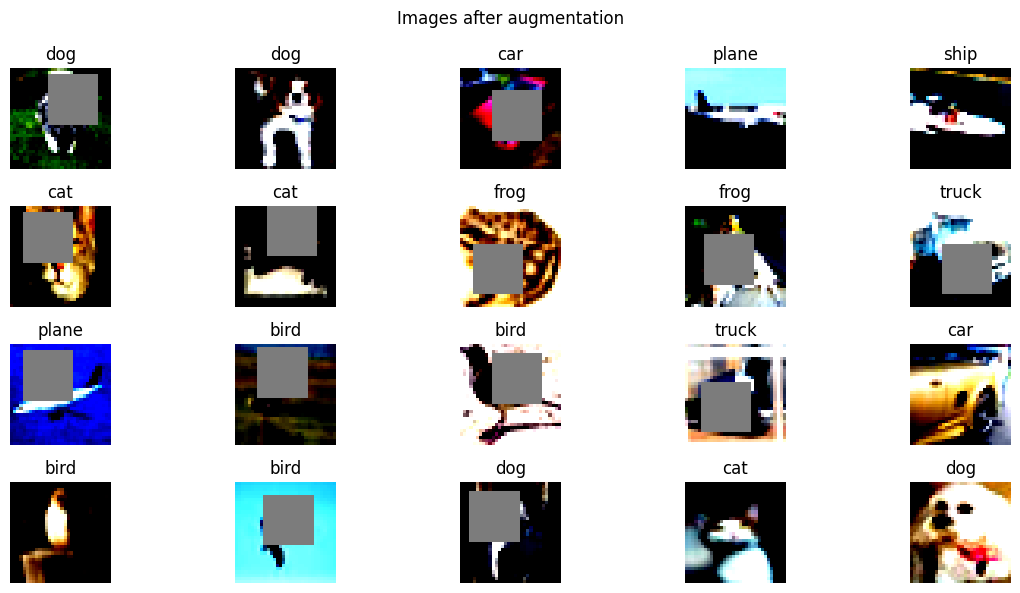

In [9]:
#visualize the data after augmentation
from utils import visualize_augmentations
data, label = next(iter(train_loader))
visualize_augmentations(data, label, 'Images after augmentation', class_map, samples=20, cols=5)

In [4]:
# variables to store accuracy and loss for plotting graphs for model later
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [5]:
#print model summary
from model import Net
model = Net(drop=0.1).to(device)
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           4,096
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

In [6]:
# get the model
import torch.nn as nn
import torch.optim as optim
from model import Net, train_model, test_model
from utils import print_epoch_progress

In [7]:


model = Net(drop=0.1).to(device)

num_epochs = 80
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.9, steps_per_epoch=len(train_loader), epochs=num_epochs)
criterion = nn.CrossEntropyLoss()


print(f'| Epoch | {"LR":8} | TrainAcc  | TrainLoss | TestAcc   | TestLoss |')

for epoch in range(1, num_epochs+1):
  train_acc, train_loss = train_model(model, device, train_loader, optimizer, criterion)
  train_accuracy.append(train_acc)
  train_losses.append(train_loss)
  test_acc, test_loss = test_model(model, device, test_loader, criterion)
  test_accuracy.append(test_acc)
  test_losses.append(test_loss)
  lr = scheduler.get_last_lr()[0]
  print_epoch_progress(epoch, lr, train_acc, train_loss, test_acc, test_loss)
  scheduler.step()

| Epoch | LR       | TrainAcc  | TrainLoss | TestAcc   | TestLoss |
|     1 | 0.036    | 33.966  % | 1.792827  | 44.79   % | 0.01192  |
|     2 | 0.036    | 44.32   % | 1.51739   | 52.02   % | 0.010375 |
|     3 | 0.036    | 49.954  % | 1.373566  | 56.0    % | 0.009711 |
|     4 | 0.036    | 53.956  % | 1.272124  | 62.23   % | 0.008297 |
|     5 | 0.036    | 56.852  % | 1.191529  | 63.42   % | 0.008038 |
|     6 | 0.036001 | 59.758  % | 1.120682  | 65.9    % | 0.007613 |
|     7 | 0.036001 | 60.952  % | 1.082529  | 69.48   % | 0.006787 |
|     8 | 0.036001 | 62.682  % | 1.039062  | 70.93   % | 0.006459 |
|     9 | 0.036002 | 64.07   % | 1.003039  | 69.61   % | 0.006717 |
|    10 | 0.036002 | 65.27   % | 0.970676  | 73.02   % | 0.006017 |
|    11 | 0.036002 | 66.77   % | 0.935425  | 72.81   % | 0.00605  |
|    12 | 0.036003 | 67.456  % | 0.912931  | 74.43   % | 0.005795 |
|    13 | 0.036003 | 68.456  % | 0.887831  | 76.62   % | 0.005237 |
|    14 | 0.036004 | 69.34   % | 0.863954  | 75.

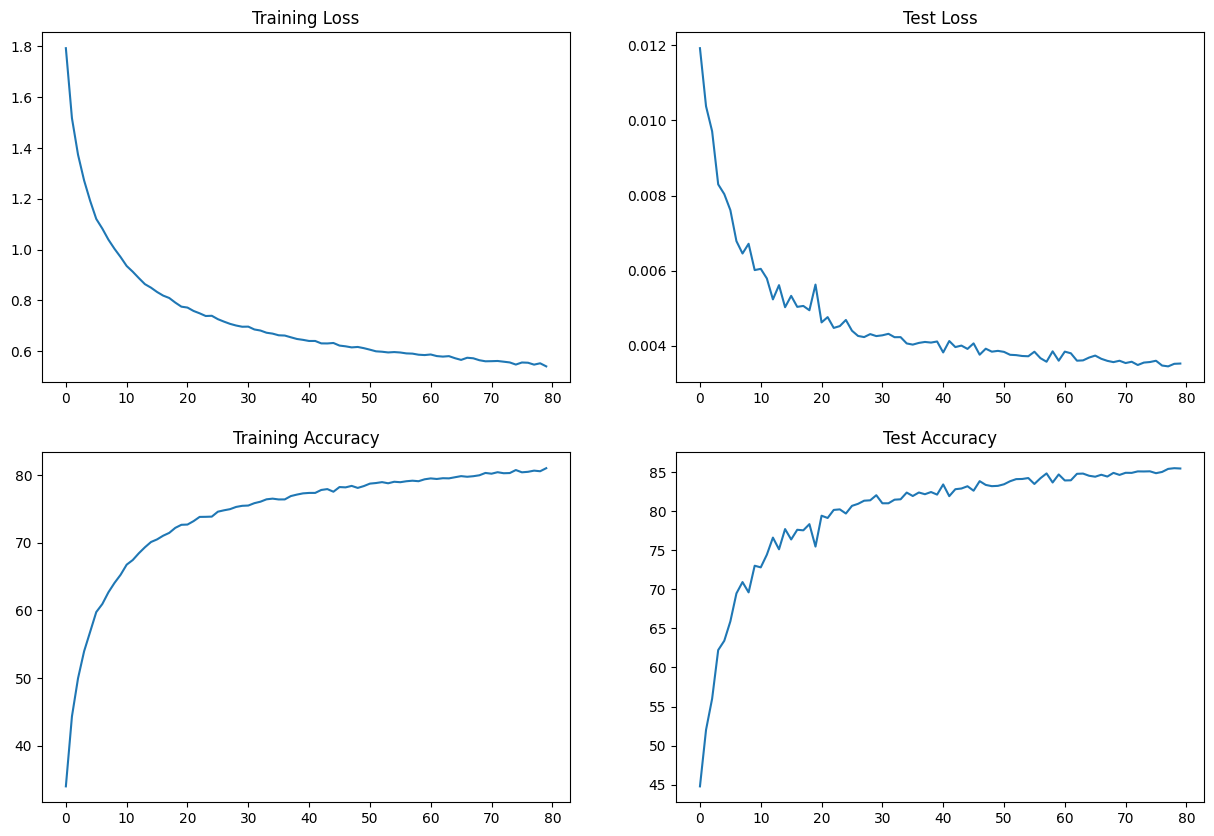

In [8]:

from utils import plot_loss_accuracy
plot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)